In [1]:

!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt

Cloning into 'Quantum_KAN'...
remote: Enumerating objects: 823, done.
remote: Counting objects: 100% (823/823), done.
remote: Compressing objects: 100% (765/765), done.
remote: Total 823 (delta 113), reused 743 (delta 55), pack-reused 0
Receiving objects: 100% (823/823), 18.18 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/Quantum_KAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [72]:
#setting
optimization_level = 2
resilience_level = 1
l = 0

In [73]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

def create_trotterized_ising_model_circuit(num_qubits, trotter_steps, time):
    """
    Trotterization을 사용하여 Ising 모델의 양자 서킷을 생성합니다.
    각 Rz 게이트의 파라미터는 Qiskit Parameter로 동적으로 설정됩니다.

    Parameters:
    - num_qubits: 큐비트의 수
    - trotter_steps: Trotterization 단계 수
    - time: 진화 시간

    Returns:
    - QuantumCircuit: 생성된 양자 서킷
    - dict: 서킷 파라미터 사전
    """
    qc = QuantumCircuit(num_qubits)
    delta_t = time / trotter_steps

    # 파라미터 설정
    h_params = [Parameter(f'h_{i}') for i in range(num_qubits)]
    J_params = [[Parameter(f'J_{i}_{j}') for j in range(num_qubits)] for i in range(num_qubits)]

    for _ in range(trotter_steps):
        # 자기 상호작용 항목 추가
        for i in range(num_qubits):
            qc.rx(2 * h_params[i] * delta_t, i)

        # 스핀 간 상호작용 항목 추가
        for i in range(num_qubits-1):
            if J_params[i][i+1] != 0:
                qc.cx(i, i+1)
                qc.rz(2 * J_params[i][i+1] * delta_t, i+1)
                qc.cx(i, i+1)

    return qc, h_params, J_params

def create_trotterized_ising_model_circuit_train(num_qubits, trotter_steps, time):
    """
    Trotterization을 사용하여 Ising 모델의 양자 서킷을 생성합니다.
    각 Rz 게이트의 파라미터는 Qiskit Parameter로 동적으로 설정됩니다.

    Parameters:
    - num_qubits: 큐비트의 수
    - trotter_steps: Trotterization 단계 수
    - time: 진화 시간

    Returns:
    - QuantumCircuit: 생성된 양자 서킷
    - dict: 서킷 파라미터 사전
    """
    qc = QuantumCircuit(num_qubits)
    delta_t = time / trotter_steps

    # 파라미터 설정
    h_params = [Parameter(f'h_{i}') for i in range(num_qubits)]
    J_params = [[Parameter(f'J_{i}_{j}') for j in range(num_qubits)] for i in range(num_qubits)]

    for _ in range(trotter_steps):
        # 자기 상호작용 항목 추가
        for i in range(num_qubits):
            qc.rx(2 * h_params[i] * delta_t, i)

        # 스핀 간 상호작용 항목 추가
        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                if J_params[i][j] != 0:
                    qc.rz(2 * J_params[i][j] * delta_t, j)
    return qc, h_params, J_params

# 파라미터 설정
num_qubits = 4
trotter_steps = 2  # Trotterization 단계 수
time = 1.0  # 진화 시간

# Trotterization을 사용한 Ising 모델 서킷 생성
trotterized_ising_circuit, h_params, J_params = create_trotterized_ising_model_circuit(num_qubits, trotter_steps, time)
trotterized_ising_circuit_train, h_params, J_params = create_trotterized_ising_model_circuit_train(num_qubits, trotter_steps, time)




In [74]:
# Initialize your account
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_ibm_provider
from qiskit_aer import AerSimulator
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')

backend_name = 'ibm_nazca'
backend_error = service.backend(backend_name)

In [75]:

from qiskit import pulse
from qiskit.pulse.library import Gaussian


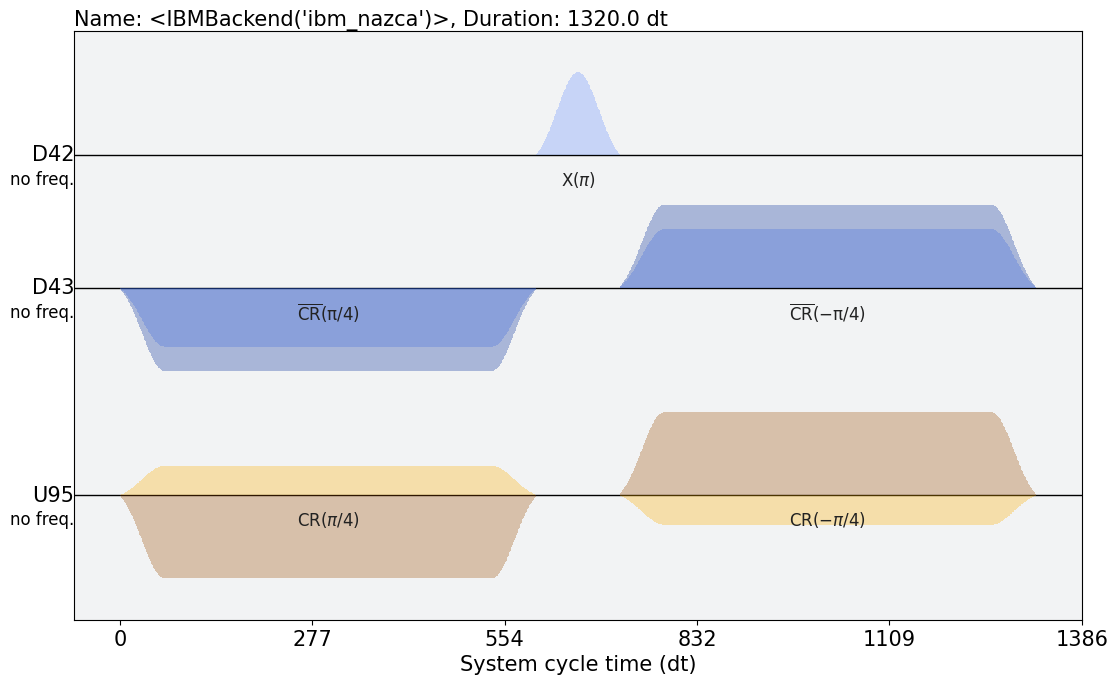

In [76]:
from qiskit import QuantumCircuit
from qiskit import pulse
from qiskit import schedule
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Options
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=[42, 43])


#qubit_use = [37,38,39,40,41,42,43]
qubit_use = [0,1,2,3,4,5,6]
circ = QuantumCircuit(2, 2)
circ.ecr(0, 1)
from qiskit import transpile
circ = passmanager.run(circ,backend_error)
pulse_schedule = schedule(circ,backend=backend_error)
pulse_schedule.draw()

In [77]:
init_list = []
for item in backend_error.target['ecr']:
    if item[0] in qubit_use and item[1] in qubit_use:
        init_list.append(item)

In [78]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel,Schedule,GaussianSquare,Drag,Play,ScheduleBlock,Delay
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 ,SamplerV2
from qiskit_ibm_runtime import Session
import numpy as np


init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)

def update_ecr(l,init_list,backend):
  layouts = {}
  for initial_layout in init_list:
    custom_gate = Gate(f"error", 2, [])
    pulse_schedule = backend.target['ecr'][initial_layout].calibration
    pulse_copy = copy.deepcopy(pulse_schedule)
    duration = round(pulse_copy.instructions[0][1].pulse.duration/32)*16
    width = round(pulse_copy.instructions[0][1].pulse._params['width']/32)*16
    x_duration = pulse_copy.instructions[2][1].pulse.duration
    sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32)*16
    pulse_real = ScheduleBlock()
    my_schedule = ScheduleBlock()
    for j in range(2):
      pulse_copy = copy.deepcopy(pulse_schedule)
      pulse_input_x_1 = pulse_copy.instructions[0][1]
      pulse_input_x_2 = pulse_copy.instructions[3][1]
      pulse_input_c_1 = pulse_copy.instructions[1][1]
      pulse_input_c_1.pulse._params['angle'] = 0
      pulse_input_c_1.pulse._params['width'] = width
      pulse_input_c_1.pulse.duration = duration
      pulse_input_c_1.pulse._params['sigma'] = sigma

      pulse_input_c_2 = pulse_copy.instructions[4][1]
      pulse_input_c_2.pulse._params['angle'] = 0
      pulse_input_c_2.pulse._params['width'] = width
      pulse_input_c_2.pulse.duration = duration
      pulse_input_c_2.pulse._params['sigma'] = sigma
      pulse_input_c_2.pulse._params['angle'] = 3.14
      pulse_input_drag = pulse_copy.instructions[2][1]
      if j == 1:
        pulse_input_drag.pulse._params['angle'] = 3.14
      real_pulse = ScheduleBlock()
      real_pulse += pulse_input_c_1
      real_pulse += Delay(x_duration,pulse_input_c_1.channel)
      real_pulse +=  pulse_input_c_2
      real_pulse += Delay(duration,pulse_input_drag.channel)
      real_pulse += pulse_input_drag
      pulse_real += real_pulse

    pulse_copy = copy.deepcopy(pulse_schedule)
    duration = round(pulse_copy.instructions[0][1].pulse.duration/32*l)*16
    width = round(pulse_copy.instructions[0][1].pulse._params['width']/32*l)*16
    x_duration = pulse_copy.instructions[2][1].pulse.duration
    sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32)*16
    for j in range(2):
      pulse_copy = copy.deepcopy(pulse_schedule)
      pulse_input_x_1 = pulse_copy.instructions[0][1]
      pulse_input_x_2 = pulse_copy.instructions[3][1]
      pulse_input_c_1 = pulse_copy.instructions[1][1]
      pulse_input_c_1.pulse._params['angle'] = 0
      pulse_input_c_1.pulse._params['width'] = width
      pulse_input_c_1.pulse.duration = duration
      pulse_input_c_1.pulse._params['sigma'] = sigma

      pulse_input_c_2 = pulse_copy.instructions[4][1]
      pulse_input_c_2.pulse._params['angle'] = 0
      pulse_input_c_2.pulse._params['width'] = width
      pulse_input_c_2.pulse.duration = duration
      pulse_input_c_2.pulse._params['sigma'] = sigma
      pulse_input_c_2.pulse._params['angle'] = 3.14
      pulse_input_drag = pulse_copy.instructions[2][1]
      if j == 1:
        pulse_input_drag.pulse._params['angle'] = 3.14
      real_pulse = ScheduleBlock()
      real_pulse += pulse_input_c_1
      real_pulse += Delay(x_duration,pulse_input_c_1.channel)
      real_pulse +=  pulse_input_c_2
      real_pulse += Delay(duration,pulse_input_drag.channel)
      real_pulse += pulse_input_drag
      my_schedule += real_pulse

    if l == 0:
      backend.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real)))
    else:
      backend.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real+my_schedule)))



  return my_schedule,real_pulse


my_schedule,pulse_real = update_ecr(l,init_list,backend_error)
initial_layout = init_list[0]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend_error, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


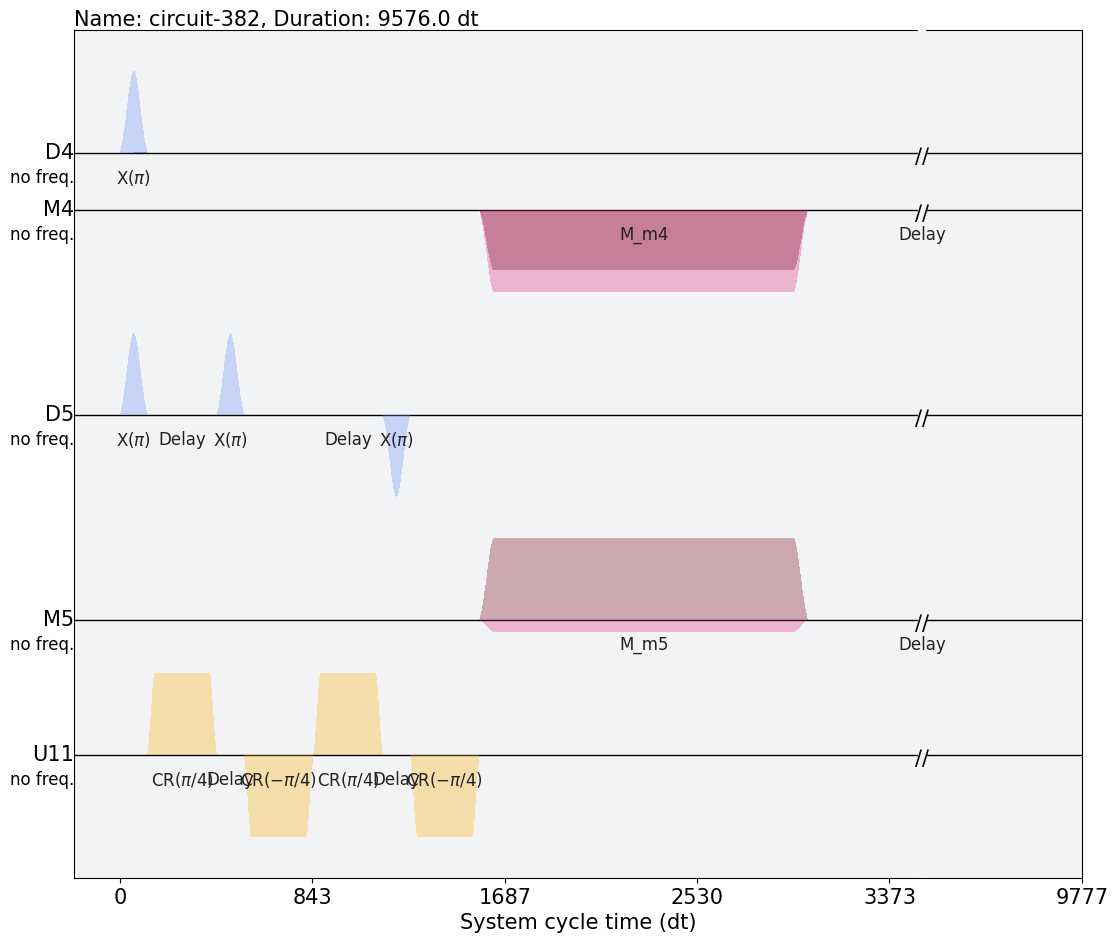

In [79]:
schedule(qc1,backend=backend_error).draw()

In [80]:

passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend_error, initial_layout=qubit_use[:4])

from qiskit.quantum_info import SparsePauliOp
"""
qc_list = []
for i in range(20):
    qc1 = QuantumCircuit(2, 2)
    if init[0] == '1':
        qc1.x(0)
    if init[1] == '1':
        qc1.x(1)
    #qc1.ecr(0,1)
    #qc1.ecr(0,1)
    for j in range(i):
        qc1.ecr(0,1)
        qc1.ecr(0,1)
    qc1.measure(0,0)
    qc1.measure(1,1)
    qc1 = passmanager.run(qc1)
    qc_list.append(qc1)"""
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,len(trotterized_ising_circuit.parameters)])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)
with Session(backend=backend_error,) as session:
    estimator = EstimatorV2(backend=backend_error)
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
    #job = sampler.run(qc_list,shots=8000)
    job.update_tags(['ecr_train',f"l={1+l}"])

In [68]:
service = QiskitRuntimeService(channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token = '06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854')


backend = service.backend(backend_name)

In [69]:
import copy
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.pulse import builder, DriveChannel
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2,SamplerV2
from qiskit_ibm_runtime import Session
init = '11'


error_gate = Gate(f"error", 2, [])
qc1 = QuantumCircuit(2, 2)
if init[0] == '1':
  qc1.x(0)
if init[1] == '1':
  qc1.x(1)
qc1.ecr(0,1)
qc1.ecr(0,1)
qc1.measure(0,0)
qc1.measure(1,1)
def update_ecr_real(l,init_list,backend):
  layouts = {}
  for initial_layout in init_list:
    custom_gate = Gate(f"error", 2, [])
    pulse_schedule = backend.target['ecr'][initial_layout].calibration
    pulse_real = copy.deepcopy(pulse_schedule)

    my_schedule = Schedule()
    pulse_copy = copy.deepcopy(pulse_schedule)
    duration = round(pulse_copy.instructions[0][1].pulse.duration/32*l)*16
    width = round(pulse_copy.instructions[0][1].pulse._params['width']/32*l)*16
    x_duration = pulse_copy.instructions[2][1].pulse.duration
    sigma = round(pulse_copy.instructions[0][1].pulse._params['sigma']/32)*16
    for j in range(2):
      pulse_copy = copy.deepcopy(pulse_schedule)
      pulse_input_x_1 = pulse_copy.instructions[0][1]
      pulse_input_x_2 = pulse_copy.instructions[3][1]
      pulse_input_c_1 = pulse_copy.instructions[1][1]
      pulse_input_c_1.pulse._params['angle'] = 0
      pulse_input_c_1.pulse._params['width'] = width
      pulse_input_c_1.pulse.duration = duration
      pulse_input_c_1.pulse._params['sigma'] = sigma

      pulse_input_c_2 = pulse_copy.instructions[4][1]
      pulse_input_c_2.pulse._params['angle'] = 0
      pulse_input_c_2.pulse._params['width'] = width
      pulse_input_c_2.pulse.duration = duration
      pulse_input_c_2.pulse._params['sigma'] = sigma
      pulse_input_c_2.pulse._params['angle'] = 3.14
      pulse_input_drag = pulse_copy.instructions[2][1]
      if j == 1:
        pulse_input_drag.pulse._params['angle'] = 3.14
      real_pulse = Schedule(pulse_input_c_1)
      real_pulse +=  Schedule((x_duration,pulse_input_c_2))
      real_pulse += Schedule((duration,pulse_input_drag))
      my_schedule += real_pulse

    if l == 0:
      backend.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real)))
    else:
      backend.target.update_instruction_properties(f'ecr',initial_layout,properties = InstructionProperties(calibration=(pulse_real+my_schedule)))



  return my_schedule,real_pulse





update_ecr_real(l,init_list,backend)
initial_layout = init_list[1]
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=list(initial_layout))
qc1 = passmanager.run(qc1)


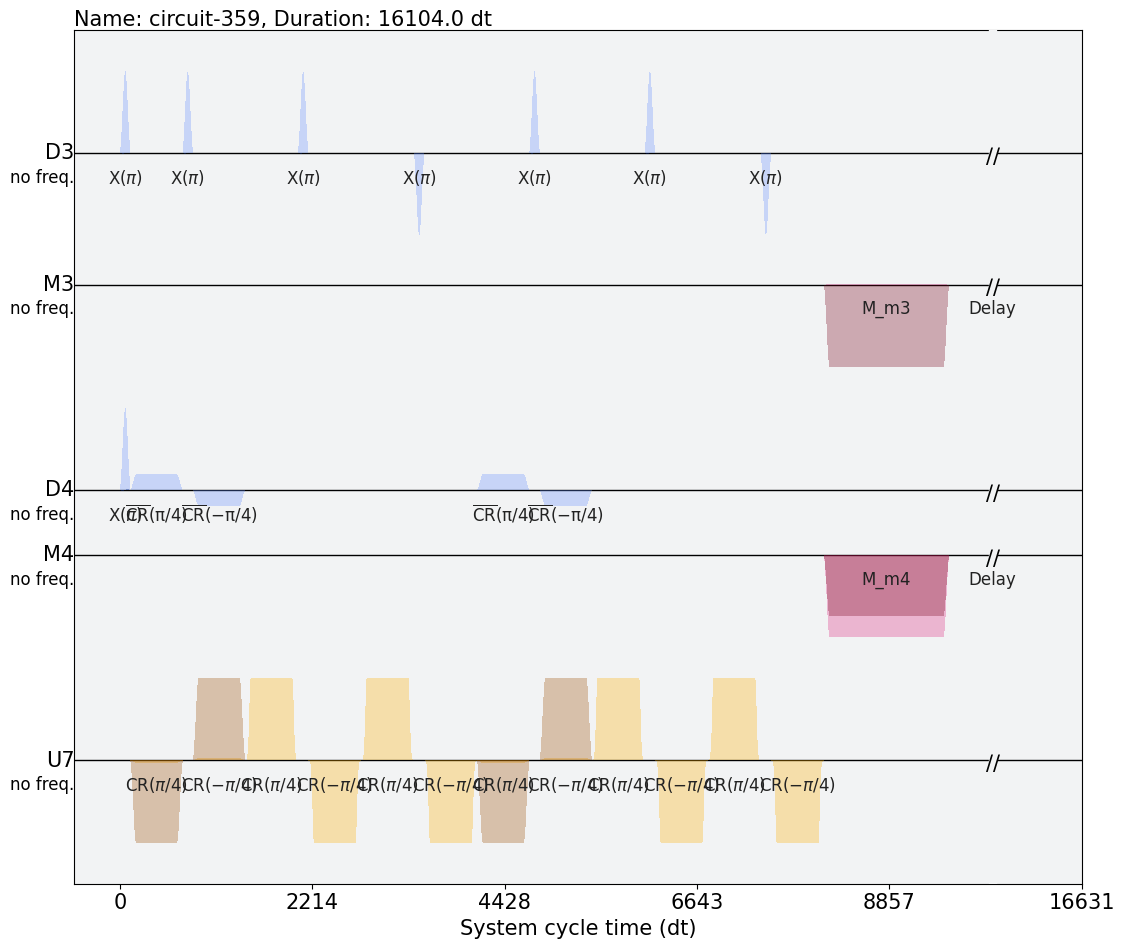

In [70]:
schedule(qc1,backend=backend).draw()

In [71]:
passmanager = generate_preset_pass_manager(optimization_level=optimization_level, backend=backend, initial_layout=qubit_use[:4])

from qiskit.quantum_info import SparsePauliOp
"""
qc_list = []
for i in range(20):
    qc1 = QuantumCircuit(2, 2)
    if init[0] == '1':
        qc1.x(0)
    if init[1] == '1':
        qc1.x(1)
    #qc1.ecr(0,1)
    #qc1.ecr(0,1)
    for j in range(i):
        qc1.ecr(0,1)
        qc1.ecr(0,1)
    qc1.measure(0,0)
    qc1.measure(1,1)
    qc1 = passmanager.run(qc1)
    qc_list.append(qc1)"""
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,len(trotterized_ising_circuit.parameters)])
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
qc_input = passmanager.run(trotterized_ising_circuit)
isa_observables = hamiltonian.apply_layout(qc_input.layout)



with Session(backend=backend) as session:
    estimator = EstimatorV2(session=session)
    estimator.resilience_level = resilience_level
    job = estimator.run([(qc_input, isa_observables, theta[i]) for i in range(100)])
    #job = sampler.run(qc_list,shots=8000)
    job.update_tags(['ecr',f"l={1+l}"])

In [16]:
from qiskit.primitives import StatevectorEstimator
import torch
from qiskit.quantum_info import SparsePauliOp
np.random.seed(30)
theta = np.random.uniform(-3.14, 3.14, [100,len(trotterized_ising_circuit.parameters)])
estimator = StatevectorEstimator()
hamiltonian = SparsePauliOp.from_list([("ZIII", 1), ("IZII", 1), ("IIZI", 1),("IIIZ", 1)])
job_train = estimator.run([(trotterized_ising_circuit_train, hamiltonian, theta[i]) for i in range(100)])
job_valid = estimator.run([(trotterized_ising_circuit, hamiltonian, theta[i]) for i in range(100)])

In [17]:
train_label = torch.tensor(np.array([result.data.evs for result in job_train.result()]),dtype=torch.float32)
validation_label = torch.tensor(np.array([result.data.evs for result in job_valid.result()]),dtype=torch.float32)

In [41]:
torch.stack([train_label,train_set[0]],dim=1)

tensor([[ 2.3758e+00,  1.9867e-01],
        [-3.5674e-01,  1.1696e-01],
        [ 2.9056e+00,  1.1627e-01],
        [-6.3844e-03, -9.9271e-02],
        [ 1.2500e+00, -1.1046e-01],
        [ 4.0415e-01,  2.9705e-02],
        [ 9.3455e-01, -1.0619e-01],
        [ 3.0268e-01, -3.1345e-03],
        [-4.8725e-01,  1.4526e-01],
        [ 9.2050e-01, -2.6590e-02],
        [ 2.1321e+00,  3.8626e-02],
        [ 2.8156e+00, -1.3976e-02],
        [ 1.6701e+00,  1.8557e-01],
        [ 1.3038e+00, -1.6503e-01],
        [ 1.5118e+00, -1.2052e-01],
        [ 2.8088e+00,  8.2369e-02],
        [ 1.2832e-01,  7.9270e-02],
        [ 1.4896e+00,  9.2741e-02],
        [ 2.8523e-01, -1.2394e-01],
        [ 2.1079e+00, -1.8633e-01],
        [ 2.2914e+00, -2.5155e-02],
        [ 2.4705e+00,  1.2406e-01],
        [ 9.4583e-01, -8.0643e-02],
        [ 3.2497e+00, -4.2801e-02],
        [ 3.1005e+00,  1.1101e-01],
        [ 2.0278e-01,  7.0789e-02],
        [ 3.9661e-01, -1.0183e-02],
        [ 3.1635e+00,  5.292

In [19]:
torch.stack([train_label,train_set[0]],dim=1)

tensor([[ 2.3758e+00,  1.9867e-01],
        [-3.5674e-01,  1.1696e-01],
        [ 2.9056e+00,  1.1627e-01],
        [-6.3844e-03, -9.9271e-02],
        [ 1.2500e+00, -1.1046e-01],
        [ 4.0415e-01,  2.9705e-02],
        [ 9.3455e-01, -1.0619e-01],
        [ 3.0268e-01, -3.1345e-03],
        [-4.8725e-01,  1.4526e-01],
        [ 9.2050e-01, -2.6590e-02],
        [ 2.1321e+00,  3.8626e-02],
        [ 2.8156e+00, -1.3976e-02],
        [ 1.6701e+00,  1.8557e-01],
        [ 1.3038e+00, -1.6503e-01],
        [ 1.5118e+00, -1.2052e-01],
        [ 2.8088e+00,  8.2369e-02],
        [ 1.2832e-01,  7.9270e-02],
        [ 1.4896e+00,  9.2741e-02],
        [ 2.8523e-01, -1.2394e-01],
        [ 2.1079e+00, -1.8633e-01],
        [ 2.2914e+00, -2.5155e-02],
        [ 2.4705e+00,  1.2406e-01],
        [ 9.4583e-01, -8.0643e-02],
        [ 3.2497e+00, -4.2801e-02],
        [ 3.1005e+00,  1.1101e-01],
        [ 2.0278e-01,  7.0789e-02],
        [ 3.9661e-01, -1.0183e-02],
        [ 3.1635e+00,  5.292

In [172]:
torch.nn.MSELoss()(train_label,train_set[0])

tensor(4.4591)

In [27]:
torch.nn.MSELoss()(validation_label, valid_set[0])

tensor(6.7195)

In [26]:
torch.stack([validation_label, valid_set[0],valid_set[1],valid_set[2]],dim=1)

tensor([[ 1.5949e+00, -2.2272e-01, -1.2859e-01, -2.4943e-01],
        [ 6.6771e-01, -2.3737e-01, -2.0447e-01, -1.8575e-01],
        [ 2.8194e+00, -3.8952e-01, -3.1305e-01, -4.4560e-01],
        [ 1.2064e+00, -6.4769e-01, -5.8568e-01, -6.2487e-01],
        [ 2.2704e+00, -7.8662e-01, -7.9108e-01, -8.3204e-01],
        [ 2.3728e+00,  3.9042e-01,  3.6038e-01,  4.2562e-01],
        [ 1.8065e+00, -1.7508e-01, -2.3658e-01, -2.9924e-01],
        [ 2.0651e+00, -3.1303e-02, -2.1805e-02,  2.6788e-02],
        [ 1.3334e+00,  5.3467e-01,  5.7462e-01,  5.8423e-01],
        [ 9.7672e-01,  2.0945e-01,  1.3545e-01,  1.0465e-01],
        [ 2.3975e+00, -2.8428e-01, -3.0344e-01, -3.3071e-01],
        [ 3.0344e+00, -6.3436e-01, -5.8667e-01, -6.6292e-01],
        [ 2.1315e+00,  2.1986e-01,  2.0858e-01,  1.2208e-01],
        [ 1.6236e+00, -1.8998e-01, -2.1649e-01, -2.3949e-01],
        [ 2.1018e+00, -3.8011e-01, -2.9701e-01, -3.0884e-01],
        [ 2.1714e+00, -3.0383e-01, -3.1876e-01, -3.9888e-01],
        

In [ ]:
torch.nn.MSELoss()(validation_label, valid_set[1])

tensor(5.9628)

In [ ]:
torch.sum(abs(validation_label)),torch.sum(abs(train_set[0]))

(tensor(179.8222), tensor(43.0763))

In [25]:
import torch
l_list = [1,1.5,2,2.5,3]
train_set = []
valid_set = []

for l in l_list:
  train_list = []
  valid_list = []

  job_train = service.jobs(backend_name=backend_name,job_tags=['ecr_train',f'l={l}'],pending=False)
  job_valid = service.jobs(backend_name=backend_name,job_tags=['ecr',f'l={l}'],pending=False)
  for res in job_train[0].result():
    train_list.append(res.data.evs)

  for res in job_valid[0].result():
    valid_list.append(res.data.evs)

  train_set.append(torch.tensor(np.array(train_list),dtype=torch.float32))
  valid_set.append(torch.tensor(np.array(valid_list),dtype=torch.float32))


In [28]:
inputs = job_train[0].inputs

In [29]:
train_data = torch.stack(train_set,dim=1)
train_data = train_data.to(torch.float32)
validation_data = torch.stack(valid_set,dim=1)
validation_data = validation_data.to(torch.float32)

<ipython-input-35-ad3428b33d29>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_label))
<ipython-input-35-ad3428b33d29>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_dataset = TensorDataset(torch.tensor(validation_data), torch.tensor(validation_label))


Epoch 1/200, Training Loss: 4.675389695167541, Validation Loss: 5.544182443618775
Epoch 2/200, Training Loss: 4.175912547111511, Validation Loss: 4.86900475025177
Epoch 3/200, Training Loss: 3.5422868013381956, Validation Loss: 3.9082090139389036
Epoch 4/200, Training Loss: 2.6340675830841063, Validation Loss: 2.2868415296077726
Epoch 5/200, Training Loss: 1.6665360927581787, Validation Loss: 0.9065173655748368
Epoch 6/200, Training Loss: 1.429744017124176, Validation Loss: 0.8995088040828705
Epoch 7/200, Training Loss: 1.3346770793199538, Validation Loss: 1.0361928462982177
Epoch 8/200, Training Loss: 1.3948744118213654, Validation Loss: 1.2462399363517762
Epoch 9/200, Training Loss: 1.3602738201618194, Validation Loss: 1.0414297044277192
Epoch 10/200, Training Loss: 1.371652638912201, Validation Loss: 0.9520472705364227
Epoch 11/200, Training Loss: 1.3652928173542023, Validation Loss: 1.079255712032318
Epoch 12/200, Training Loss: 1.4034480512142182, Validation Loss: 0.99185817241668

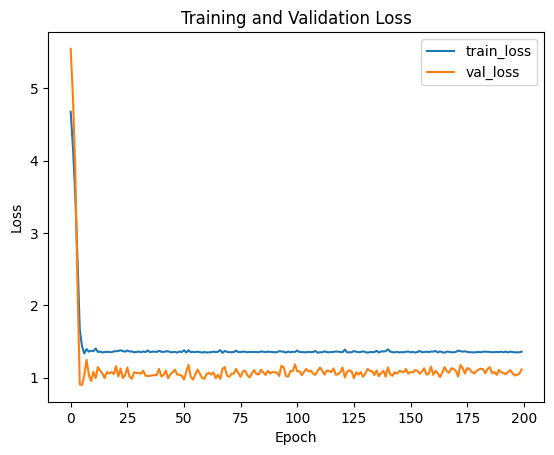

<built-in method stack of type object at 0x7a89e3481760>


<ipython-input-35-ad3428b33d29>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([5,3,1],grid=1)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output


# 데이터셋 및 데이터로더
train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_label))
validation_dataset = TensorDataset(torch.tensor(validation_data), torch.tensor(validation_label))
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=10, shuffle=False)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(5, 64)
        self.layer2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 은닉 상태 초기화
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 셀 상태 초기화
        out, _ = self.lstm(x, (h0, c0))  # LSTM을 통해 시퀀스 처리
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 fully connected layer에 적용하여 출력 생성
        return out

# 모델 초기화
model = LSTMModel(1,64,1)
# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 200
train_losses = []
validation_losses = []

for epoch in range(num_epochs):

    running_loss = 0.0
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))


    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    validation_losses.append(validation_loss / len(validation_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {validation_losses[-1]}')

# 손실(loss) 그래프
plt.plot(train_losses, label='train_loss')
plt.plot(validation_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 검증 데이터로 예측
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = model(validation_inputs)
    print(torch.stack)


In [36]:
with torch.no_grad():
    validation_inputs = torch.tensor(validation_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([predictions,validation_data[:,0],validation_label],dim=1))

tensor([[ 1.6785e+00, -2.2272e-01,  1.5949e+00],
        [ 1.6794e+00, -2.3737e-01,  6.6771e-01],
        [ 1.6602e+00, -3.8952e-01,  2.8194e+00],
        [ 1.6395e+00, -6.4769e-01,  1.2064e+00],
        [ 1.6236e+00, -7.8662e-01,  2.2704e+00],
        [ 1.7170e+00,  3.9042e-01,  2.3728e+00],
        [ 1.6614e+00, -1.7508e-01,  1.8065e+00],
        [ 1.6949e+00, -3.1303e-02,  2.0651e+00],
        [ 1.7066e+00,  5.3467e-01,  1.3334e+00],
        [ 1.7084e+00,  2.0945e-01,  9.7672e-01],
        [ 1.6851e+00, -2.8428e-01,  2.3975e+00],
        [ 1.6330e+00, -6.3436e-01,  3.0344e+00],
        [ 1.6953e+00,  2.1986e-01,  2.1315e+00],
        [ 1.6792e+00, -1.8998e-01,  1.6236e+00],
        [ 1.6633e+00, -3.8011e-01,  2.1018e+00],
        [ 1.6664e+00, -3.0383e-01,  2.1714e+00],
        [ 1.6813e+00, -1.4475e-01,  1.0192e+00],
        [ 1.7100e+00,  2.7151e-01,  2.7841e+00],
        [ 1.6713e+00, -1.5555e-01,  5.9596e-01],
        [ 1.6552e+00, -5.5083e-01,  3.3604e+00],
        [ 1.6906e+00

<ipython-input-36-b6e9f168afab>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(validation_data)


In [38]:
with torch.no_grad():
    validation_inputs = torch.tensor(train_data)
    predictions = torch.squeeze(model(validation_inputs))
    print(torch.stack([predictions,train_data[:,0],train_label],dim=1))

tensor([[ 1.7011e+00,  1.9867e-01,  2.3758e+00],
        [ 1.7003e+00,  1.1696e-01, -3.5674e-01],
        [ 1.6973e+00,  1.1627e-01,  2.9056e+00],
        [ 1.6896e+00, -9.9271e-02, -6.3844e-03],
        [ 1.6884e+00, -1.1046e-01,  1.2500e+00],
        [ 1.6960e+00,  2.9705e-02,  4.0415e-01],
        [ 1.6891e+00, -1.0619e-01,  9.3455e-01],
        [ 1.6925e+00, -3.1345e-03,  3.0268e-01],
        [ 1.6983e+00,  1.4526e-01, -4.8725e-01],
        [ 1.6923e+00, -2.6590e-02,  9.2050e-01],
        [ 1.6953e+00,  3.8626e-02,  2.1321e+00],
        [ 1.6954e+00, -1.3976e-02,  2.8156e+00],
        [ 1.7023e+00,  1.8557e-01,  1.6701e+00],
        [ 1.6878e+00, -1.6503e-01,  1.3038e+00],
        [ 1.6938e+00, -1.2052e-01,  1.5118e+00],
        [ 1.6971e+00,  8.2369e-02,  2.8088e+00],
        [ 1.6969e+00,  7.9270e-02,  1.2832e-01],
        [ 1.6936e+00,  9.2741e-02,  1.4896e+00],
        [ 1.6927e+00, -1.2394e-01,  2.8523e-01],
        [ 1.6841e+00, -1.8633e-01,  2.1079e+00],
        [ 1.6889e+00

<ipython-input-38-a6e22bbf2531>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_inputs = torch.tensor(train_data)


In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-skku/skku/skku-students',
    token='06f802eeac992c43c4106753d7c5fc31414a13eb7d91c99d67fb49cc50569e5b4b011f20c71b9607a07cb43ecc7044557c699022db91d1685ba4c886d5886854'
)
job = service.job('csjt5xf1k2e0008nt9kg')
job_result = job.result()
ZNE_result = []
for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs,validation_label[idx]}")
    ZNE_result.append(pub_result.data.evs)
ZNE_result = torch.tensor(np.array(ZNE_result),dtype=torch.float32)

RuntimeJobNotFound: 'Job not found: 404 Client Error: Not Found for url: https://api.quantum.ibm.com/runtime/jobs/csjt5xf1k2e0008nt9kg?exclude_params=true. {"errors":[{"code":1291,"message":"Job not found. Job ID: csjt5xf1k2e0008nt9kg","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}'

In [ ]:
ZNE_result = torch.tensor(np.array(ZNE_result),dtype=torch.float32)

In [ ]:
criterion(ZNE_result,validation_label)

tensor(2.1584)